# Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras import Model

tf.__version__

'2.12.0'

In [2]:
SLICE_DURATION = 0.5
SAMPLING_RATE = 16000
N_FFT = 512
HOP_LENGTH = N_FFT // 4
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
N_MELS=512
F_MAX = 8000

N_KERNELS = 10
N_FILTERS = 1

In [3]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [4]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [5]:
random_slice = slices[np.random.randint(len(slices))]

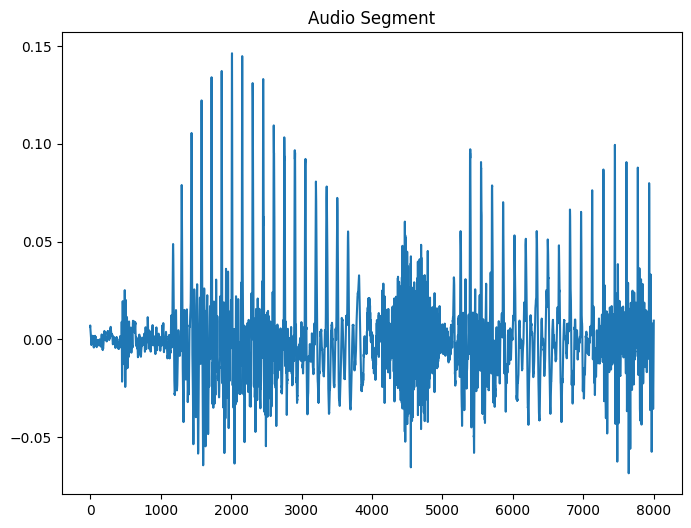

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [7]:
def get_stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH):
    ft = librosa.stft(audio_slice, n_fft=n_fft, hop_length=hop_length)
    return abs(ft)

In [8]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

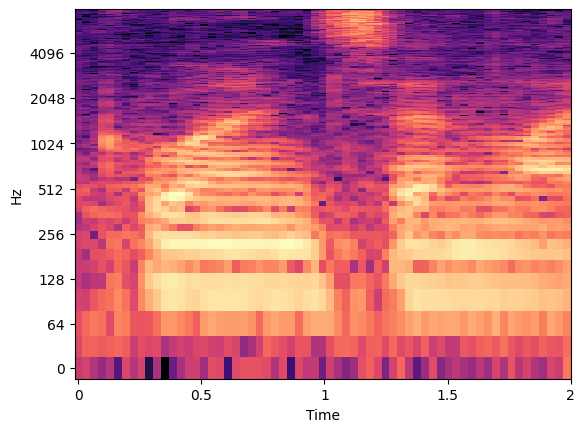

In [9]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [10]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [11]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((11, 257, 63),
 array([[0.37868667, 0.16118358, 0.0022772 , ..., 0.04731292, 0.02009557,
         0.11607045],
        [0.41716045, 0.1805397 , 0.04292458, ..., 0.11435083, 0.07428731,
         0.0990029 ],
        [0.69849336, 0.47168788, 0.30222714, ..., 0.31705368, 0.10167963,
         0.11859108],
        ...,
        [0.00153993, 0.00114687, 0.00098441, ..., 0.00601246, 0.00168526,
         0.00127035],
        [0.0017948 , 0.00086927, 0.00128968, ..., 0.00642673, 0.00109031,
         0.00181469],
        [0.00183915, 0.0012264 , 0.00144389, ..., 0.00638454, 0.00127395,
         0.00194889]], dtype=float32))

In [12]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(257, 63)

# Create Train and Test Splits

In [13]:
male_voice_dir = "males"
female_voice_dir = "females"

In [14]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [15]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [16]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Models

## STFT Based Model

In [17]:
def audio_preprocess_stft(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_stfts, labels

In [18]:
def set_tensor_shapes_stft(slice_data, label):
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [19]:
train_dataset_stft = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_stft = train_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_stft = train_dataset_stft.map(set_tensor_shapes_stft)

train_dataset_stft = train_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset_stft = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_stft = val_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_stft = val_dataset_stft.map(set_tensor_shapes_stft)

val_dataset_stft = val_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [62]:
for audio_slice, label in train_dataset_stft.take(2):
    print(audio_slice.shape)
    print(label.shape)

(128, 257, 63, 1)
(128,)
(128, 257, 63, 1)
(128,)


2023-06-13 00:20:25.974049: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [63]:
for audio_slice, label in val_dataset_stft.take(2):
    print(audio_slice.shape)
    print(label.shape)

(128, 257, 63, 1)
(128,)
(128, 257, 63, 1)
(128,)


2023-06-13 00:20:33.693652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn_stft = Model(inputs, outputs)

In [22]:
model_cnn_stft.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
history_cnn_stft = model_cnn_stft.fit(train_dataset_stft,
                        epochs=10,
                        validation_data=val_dataset_stft)

Epoch 1/10
568/568 [==============================] - 84s 37ms/step - loss: 0.5515 - accuracy: 0.7499 - val_loss: 0.5200 - val_accuracy: 0.7941
Epoch 2/10
568/568 [==============================] - 15s 27ms/step - loss: 0.4530 - accuracy: 0.8013 - val_loss: 0.4435 - val_accuracy: 0.8091
Epoch 3/10
568/568 [==============================] - 15s 27ms/step - loss: 0.4160 - accuracy: 0.8195 - val_loss: 0.4120 - val_accuracy: 0.8228
Epoch 4/10
568/568 [==============================] - 15s 27ms/step - loss: 0.3950 - accuracy: 0.8282 - val_loss: 0.3918 - val_accuracy: 0.8348
Epoch 5/10
568/568 [==============================] - 13s 23ms/step - loss: 0.3808 - accuracy: 0.8355 - val_loss: 0.3796 - val_accuracy: 0.8427
Epoch 6/10
568/568 [==============================] - 13s 23ms/step - loss: 0.3721 - accuracy: 0.8404 - val_loss: 0.3718 - val_accuracy: 0.8483
Epoch 7/10
568/568 [==============================] - 15s 26ms/step - loss: 0.3659 - accuracy: 0.8439 - val_loss: 0.3664 - val_accuracy:

In [67]:
model_cnn_stft.evaluate(val_dataset_stft)

65/65 [==============================] - 1s 9ms/step - loss: 0.3563 - accuracy: 0.8588


[0.3563012480735779, 0.8587790727615356]

## Mel Spectogram Based Model

In [23]:
def get_mel_spec(audio_slice, sampling_rate=SAMPLING_RATE, n_mels=N_MELS, f_max=F_MAX):
    return librosa.feature.melspectrogram(y=audio_slice, sr=sampling_rate, n_mels=n_mels, fmax=f_max)

In [24]:
def plot_mel_spec(mel_spec, sampling_rate=SAMPLING_RATE, f_max=F_MAX):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        spec_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=f_max,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

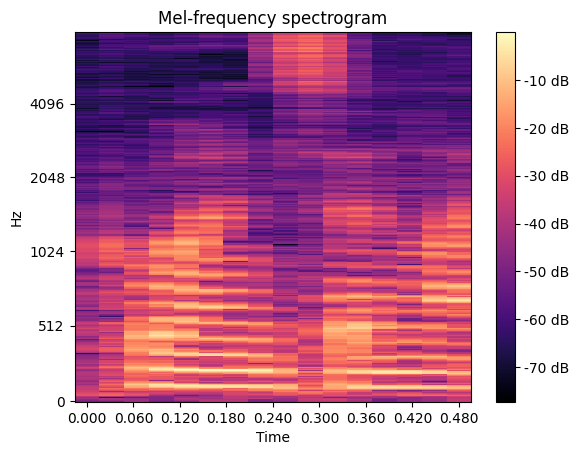

In [25]:
mel_spec = get_mel_spec(random_slice)
plot_mel_spec(mel_spec)

In [26]:
def get_audio_slices_mel_spec(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_mel_spec(audio_slice) for audio_slice in audio_slices])

In [27]:
mel_spec = get_audio_slices_mel_spec("males/0.wav")
mel_spec.shape, mel_spec[0]

((11, 512, 16),
 array([[1.5343648e-02, 2.2707530e-03, 6.3556613e-04, ..., 7.6961372e-04,
         1.6922117e-03, 2.3563402e-03],
        [1.6683640e-02, 4.7768499e-03, 7.1176671e-04, ..., 4.4551253e-04,
         1.4635483e-03, 1.1574171e-03],
        [1.7951924e-02, 7.1277074e-03, 7.6972105e-04, ..., 1.4587338e-04,
         1.2581173e-03, 5.2067153e-05],
        ...,
        [4.3974379e-07, 3.5158098e-07, 2.3829263e-07, ..., 6.9520115e-03,
         1.7841004e-03, 1.4875175e-05],
        [2.7125165e-07, 3.5617936e-07, 2.6731485e-07, ..., 1.0456585e-03,
         1.4704619e-04, 4.8881761e-06],
        [7.6169295e-07, 1.3532040e-06, 7.0458168e-07, ..., 2.0840587e-03,
         4.0303520e-04, 1.2352006e-05]], dtype=float32))

In [28]:
MEL_SPEC_SHAPE = mel_spec.shape[-2:]
MEL_SPEC_SHAPE

(512, 16)

In [29]:
def audio_preprocess_mel_spec(file_path, label):
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([tf.expand_dims(slice_mel_spec, -1) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [30]:
def set_tensor_shapes_mel_spec(slice_data, label):
    slice_data.set_shape(MEL_SPEC_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [31]:
train_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_mel_spec = train_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_mel_spec = train_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

train_dataset_mel_spec = train_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [32]:
val_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_mel_spec = val_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_mel_spec = val_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

val_dataset_mel_spec = val_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [33]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_mel_spec = Model(inputs, outputs)

In [34]:
model_cnn_mel_spec.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
history_cnn_mel_spec = model_cnn_mel_spec.fit(train_dataset_mel_spec,
                        epochs=10,
                        validation_data=val_dataset_mel_spec)

Epoch 1/10


2023-06-13 00:37:53.802932: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 704s 146ms/step - loss: 0.6539 - accuracy: 0.6562 - val_loss: 0.6387 - val_accuracy: 0.6726
Epoch 2/10
568/568 [==============================] - 8s 13ms/step - loss: 0.5424 - accuracy: 0.7465 - val_loss: 0.5044 - val_accuracy: 0.8044
Epoch 3/10
568/568 [==============================] - 8s 13ms/step - loss: 0.4379 - accuracy: 0.8142 - val_loss: 0.4330 - val_accuracy: 0.8116
Epoch 4/10
568/568 [==============================] - 8s 13ms/step - loss: 0.4063 - accuracy: 0.8293 - val_loss: 0.4428 - val_accuracy: 0.8047
Epoch 5/10
568/568 [==============================] - 8s 14ms/step - loss: 0.3964 - accuracy: 0.8337 - val_loss: 0.4247 - val_accuracy: 0.8108
Epoch 6/10
568/568 [==============================] - 8s 13ms/step - loss: 0.3847 - accuracy: 0.8384 - val_loss: 0.3983 - val_accuracy: 0.8251
Epoch 7/10
568/568 [==============================] - 8s 14ms/step - loss: 0.3756 - accuracy: 0.8431 - val_loss: 0.3890 - val_accuracy: 0.8320
Epoch 8

In [37]:
model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

65/65 [==============================] - 1s 9ms/step - loss: 0.3993 - accuracy: 0.8334


[0.39928382635116577, 0.8334348797798157]